<a href="https://colab.research.google.com/github/DarekGit/FACES_DNN/blob/master/notebooks/07_01_mobilenet_ONNX_export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

[Spis treści](https://github.com/DarekGit/FACES_DNN/blob/master/notebooks/Praca_Dyplomowa.ipynb) | [1. Wstęp](01_00_Wstep.ipynb) | [2. Metryki oceny detekcji](02_00_Miary.ipynb) | [3 .Bazy danych](03_00_Datasety.ipynb) | [4. Przegląd metod detekcji](04_00_Modele.ipynb) | [5. Detekcja twarzy z wykorzystaniem wybranych architektur GSN](05_00_Modyfikacje.ipynb) | [6. Porównanie modeli](06_00_Porownanie.ipynb) | [7. Eksport modelu](07_00_Eksport_modelu.ipynb) | [8. Podsumowanie i wnioski](08_00_Podsumowanie.ipynb) | [Bibliografia](Bibliografia.ipynb)


---



# 7.1 ONNX /jit /Caffe export

# Install detectron2



In [ ]:
import os
def Wider_load(val=True,train=True,test=False):
  os.makedirs('WIDER/', exist_ok=True)

  if val:
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDd3dIRmpvSk8tLUk
    !gdown https://drive.google.com/uc?id=1-5A_pa_jDS7gk8mHVCBB7ApV5KN8jWDr -O WIDER/tempv.zip
    !unzip -q WIDER/tempv.zip -d WIDER
    !rm WIDER/tempv.zip  

  if train:
    ### WIDER Face Training Images
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDQUUwd21EckhUbWs
    !gdown https://drive.google.com/uc?id=1-1iJfmXKYvAx9uLdRDX5W6HHG_KZv1jH -O WIDER/temptr.zip
    !unzip -q WIDER/temptr.zip -d WIDER
    !rm WIDER/temptr.zip
  
  if test:
    #!gdown https://drive.google.com/uc?id=0B6eKvaijfFUDbW4tdGpaYjgzZkU
    !gdown https://drive.google.com/uc?id=1tTpUJZEQMKDVxKT6100V5FwDuGX_8sDi -O WIDER/tempt.zip
    !unzip -q WIDER/tempt.zip -d WIDER
    !rm WIDER/tempt.zip


  ### Face annotations
  !wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip -O WIDER/tempa.zip
  !unzip -q WIDER/tempa.zip -d WIDER
  !rm WIDER/tempa.zip

  #annotations tool
  !gdown https://drive.google.com/uc?id=1_9ydMZlTNFXBOMl16xsU8FSBmK2PW4lN -O WIDER/tools.py


  ### Examples and formats of the submissions
  #!wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip


In [ ]:
def repo_load():
  !pip install cython pyyaml==5.1
  !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  # install detectron2:
  !git clone https://github.com/facebookresearch/detectron2 detectron2_repo
  !pip install -q -e detectron2_repo

  !gdown https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
  !unzip -qo mobilenet.zip
  !rm -f mobilenet.zip

repo_load()

In [ ]:
Wider_load(train=False)

#ONNX


In [ ]:
# Install ONNX in Colab
!sudo apt-get install protobuf-compiler libprotoc-dev
!pip install onnx

<font color=red> Restart runtime to continue... <b>Crtl+M.</b> </font>

In [ ]:
from mobilenet.utils import  add_mobilenet_config, build_mobilenetv2_fpn_backbone
from WIDER.tools import annotations
from detectron2.data import DatasetCatalog, MetadataCatalog
import json


In [ ]:
val = annotations('val')
DatasetCatalog.register("face_val", lambda : val)
MetadataCatalog.get("face_val").set(thing_classes = ['face'])

Metadata(name='face_val', thing_classes=['face'])

In [ ]:
#Weights and cfg configuration from training

def cfg_write(cfg,cfg_all):
  for key in cfg_all.keys():
    if isinstance(cfg_all[key],dict): cfg_write(cfg[key],cfg_all[key])
    else: cfg[key]=cfg_all[key]
  return cfg

#BN_Mish_V22F2
path='model_0099999.pth'
!gdown 'https://drive.google.com/uc?id=1-ZFjV1a8Wz3wz1f1CrjPWFFChW-4aAlN'
#cfg
!gdown 'https://drive.google.com/uc?id=1D6DUFrGAb8x40S5GrvmcB73EwNSGjQnR'


with open('Base-RCNN-MobileNet-FPN_V1_ALL.json','r') as f:
      cfg_all=json.load(f)  

Downloading...
From: https://drive.google.com/uc?id=1-ZFjV1a8Wz3wz1f1CrjPWFFChW-4aAlN
To: /content/model_0099999.pth
150MB [00:01, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D6DUFrGAb8x40S5GrvmcB73EwNSGjQnR
To: /content/Base-RCNN-MobileNet-FPN_V1_ALL.json
100% 5.35k/5.35k [00:00<00:00, 4.34MB/s]


In [ ]:
def to_BN(cfg,pth=''):
  for key in cfg.keys():
    if isinstance(cfg[key],dict): to_BN(cfg[key],pth+'.'+key)
    elif key=='NORM' and 'BN' in cfg[key]: 
      print(pth+'.'+key,cfg[key],'  replaced to BN')
      cfg[key]='BN'
  return cfg

In [ ]:
import onnx
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
from detectron2.export import Caffe2Tracer, add_export_config
from detectron2.modeling import build_model



cfg = get_cfg()
add_mobilenet_config(cfg) #dolozenie mobilenet
cfg=cfg_write(cfg,cfg_all) #konfiguracja z trenowania

# cuda context is initialized before creating dataloader, so we don't fork anymore
cfg.DATALOADER.NUM_WORKERS = 0
cfg = add_export_config(cfg)

#cfg=to_BN(cfg) #konwersja do Batch Normalization
cfg.MODEL.WEIGHTS = path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.MODEL.DEVICE='cuda' #"PyTorch>=1.5 required for GPU conversion!"

# create a torch model
model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

# get a sample data
data_loader = build_detection_test_loader(cfg, 'face_val')
data = next(iter(data_loader))

In [ ]:
tracer = Caffe2Tracer(cfg, model, data )

In [ ]:
onnx_model = tracer.export_onnx()
onnx.save(onnx_model, 'Det2MobilenetV2.onnx')

In [ ]:
import copy
from detectron2.export.caffe2_export import run_and_save_graph, export_caffe2_detection_model
from detectron2.export.caffe2_modeling import META_ARCH_CAFFE2_EXPORT_TYPE_MAP

C2MetaArch = META_ARCH_CAFFE2_EXPORT_TYPE_MAP[cfg.MODEL.META_ARCHITECTURE]
traceable_model = C2MetaArch(cfg, copy.deepcopy(model))
traceable_inputs=traceable_model.get_caffe2_inputs(data)

p_net,init_net=export_caffe2_detection_model(traceable_model,traceable_inputs)
run_and_save_graph(p_net,init_net,traceable_inputs,'./graph.png')

# Porównanie wyników

In [ ]:
import numpy as np
from detectron2.engine import DefaultPredictor #przygotwuje dane wejsciowe, zmiana formatu, transformacja, ustwia h,w obrazka


predictor=DefaultPredictor(cfg)
predictor(np.array(data[0]['image'].permute(1,2,0)))['instances']

Instances(num_instances=6, image_height=800, image_width=1208, fields=[pred_boxes: Boxes(tensor([[ 152.1106,  284.1120,  160.5939,  294.5716],
        [  45.1132,  308.1608,   60.1005,  326.3912],
        [ 986.3803,  202.8079,  995.7819,  214.5099],
        [ 886.4589,  189.4491,  891.8168,  196.1882],
        [ 997.3694,  223.0052, 1004.3794,  231.9342],
        [1010.9294,  163.2809, 1017.5125,  171.5257]], device='cuda:0')), scores: tensor([0.8207, 0.7002, 0.6766, 0.6118, 0.6055, 0.5233], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0, 0, 0], device='cuda:0')])

In [ ]:
import torch
img=np.array(data[0]['image'].permute(1,2,0))[:,:,::-1].copy() #do BGR, model zawsze dziala w BGR
inputs=[{'image':torch.as_tensor(img).permute(2,0,1),'height':img.shape[0],'width':img.shape[1]}]

In [ ]:
inputs[0]['image'].size(),data[0]['height'],data[0]['width']

(torch.Size([3, 800, 1208]), 678, 1024)

In [ ]:
model.eval()
out=model.forward(inputs)
out[0]['instances'] #inny rozmiar wejsciowy

Instances(num_instances=6, image_height=800, image_width=1208, fields=[pred_boxes: Boxes(tensor([[ 152.1106,  284.1120,  160.5939,  294.5716],
        [  45.1132,  308.1608,   60.1005,  326.3912],
        [ 986.3803,  202.8079,  995.7819,  214.5099],
        [ 886.4589,  189.4491,  891.8168,  196.1882],
        [ 997.3694,  223.0052, 1004.3794,  231.9342],
        [1010.9294,  163.2809, 1017.5125,  171.5257]], device='cuda:0',
       grad_fn=<IndexBackward>)), scores: tensor([0.8207, 0.7002, 0.6766, 0.6118, 0.6055, 0.5233], device='cuda:0',
       grad_fn=<IndexBackward>), pred_classes: tensor([0, 0, 0, 0, 0, 0], device='cuda:0')])

In [ ]:
from detectron2.export.caffe2_modeling import META_ARCH_CAFFE2_EXPORT_TYPE_MAP

C2MetaArch = META_ARCH_CAFFE2_EXPORT_TYPE_MAP[cfg.MODEL.META_ARCHITECTURE]
traceable_model = C2MetaArch(cfg, copy.deepcopy(model))
traceable_inputs=traceable_model.get_caffe2_inputs(data)

In [ ]:
traceable_inputs[0].size(), traceable_inputs[1]

(torch.Size([1, 3, 800, 1216]),
 tensor([[8.0000e+02, 1.2080e+03, 8.4750e-01]], device='cuda:0'))

In [ ]:
t_inputs = (torch.as_tensor(np.array(traceable_inputs[0].cpu())[:,::-1,:,:].copy()).cuda(),traceable_inputs[1]) #do BGR

In [ ]:
outt=traceable_model.forward(t_inputs) 
outt #wynik zbilizony

(tensor([[ 152.1106,  284.1120,  160.5939,  294.5716],
         [  45.1132,  308.1608,   60.1005,  326.3911],
         [ 986.3804,  202.8079,  995.7821,  214.5099],
         [ 886.4590,  189.4491,  891.8169,  196.1882],
         [ 997.3693,  223.0052, 1004.3794,  231.9342],
         [1010.9323,  163.2839, 1017.5166,  171.5306]], device='cuda:0'),
 tensor([0.8207, 0.7002, 0.6766, 0.6118, 0.6055, 0.5246], device='cuda:0'),
 tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'))

In [ ]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

np.testing.assert_allclose(to_numpy(out[0]['instances'].scores[:5]), to_numpy(outt[1][:5]), rtol=1e-03, atol=1e-05)
print('OK')

OK


# Export z pominieciem tracer

In [ ]:
from detectron2.export import export_onnx_model
onnx_model=export_onnx_model(cfg, model, data)
onnx.save(onnx_model,'Det2MobilenetV2.onnx')

Torchscript

In [ ]:
script_model = tracer.export_torchscript() #torch.jit.trace(model, (inputs,), optimize=True)
script_model.save("./Det2MobilenetV2.ts")

In [ ]:
torch.save(t_inputs,'inputs.torch')

In [ ]:
test_model=torch.jit.load('Det2MobilenetV2.ts')

In [ ]:
outtest=test_model.forward(t_inputs) 
outtest #wynik zbilizony

(tensor([[ 152.1106,  284.1120,  160.5939,  294.5716],
         [  45.1132,  308.1608,   60.1005,  326.3911],
         [ 986.3804,  202.8079,  995.7821,  214.5099],
         [ 886.4590,  189.4491,  891.8169,  196.1882],
         [ 997.3693,  223.0052, 1004.3794,  231.9342],
         [1010.9323,  163.2839, 1017.5166,  171.5306]], device='cuda:0'),
 tensor([0.8207, 0.7002, 0.6766, 0.6118, 0.6055, 0.5246], device='cuda:0'),
 tensor([0., 0., 0., 0., 0., 0.], device='cuda:0'))

Caffe2 model

In [ ]:
caffe2_model = tracer.export_caffe2()
caffe2_model.save_protobuf('Det2MobilenetV2.caffe2')
# draw the caffe2 graph
caffe2_model.save_graph("./Det2MobilenetV2_caffe2.png", inputs=data)

Caffe2 evaluation

In [ ]:
caffe2_model

Caffe2Model(
  (_predictor): ProtobufDetectionModel(
    (protobuf_model): ProtobufModel()
  )
)

In [ ]:
  import os
  from detectron2.evaluation import COCOEvaluator, inference_on_dataset, print_csv_format
  
  output_path='OUTPUT'
  dataset = cfg.DATASETS.TEST[0]
  data_loader = build_detection_test_loader(cfg, dataset)
  # NOTE: hard-coded evaluator. change to the evaluator for your dataset
  os.makedirs(output_path, exist_ok=True)
  evaluator = COCOEvaluator(dataset, cfg, True, output_path)
  metrics = inference_on_dataset(caffe2_model, data_loader, evaluator)
  print_csv_format(metrics)

json_file was not found in MetaDataCatalog for 'face_val'. Trying to convert it to COCO format ...


Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=55.91s).
Accumulating evaluation results...
DONE (t=0.56s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.560
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.212
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.335
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

In [ ]:
! pip install onnxruntime

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("Det2MobilenetV2.onnx")

In [ ]:
import onnxruntime

torch_out = traceable_model(traceable_inputs)
ort_session = onnxruntime.InferenceSession("BN_Mish_V2F2.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

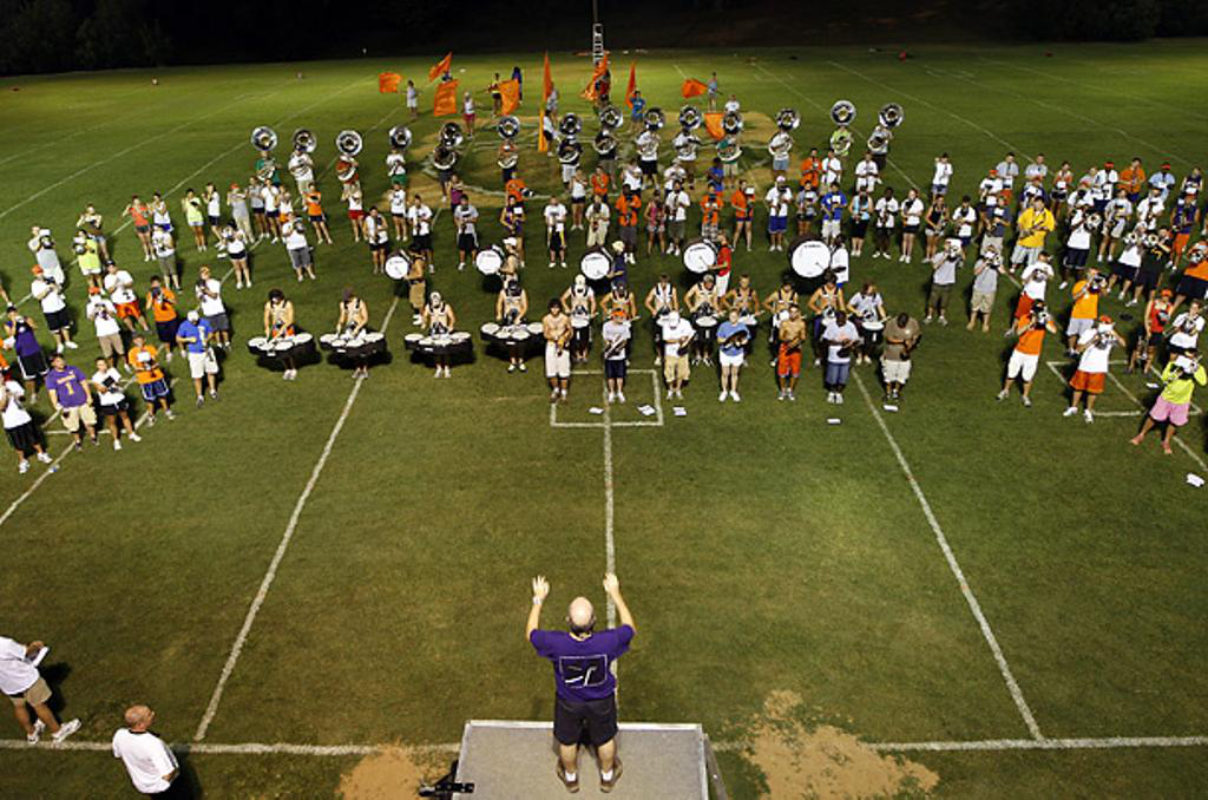

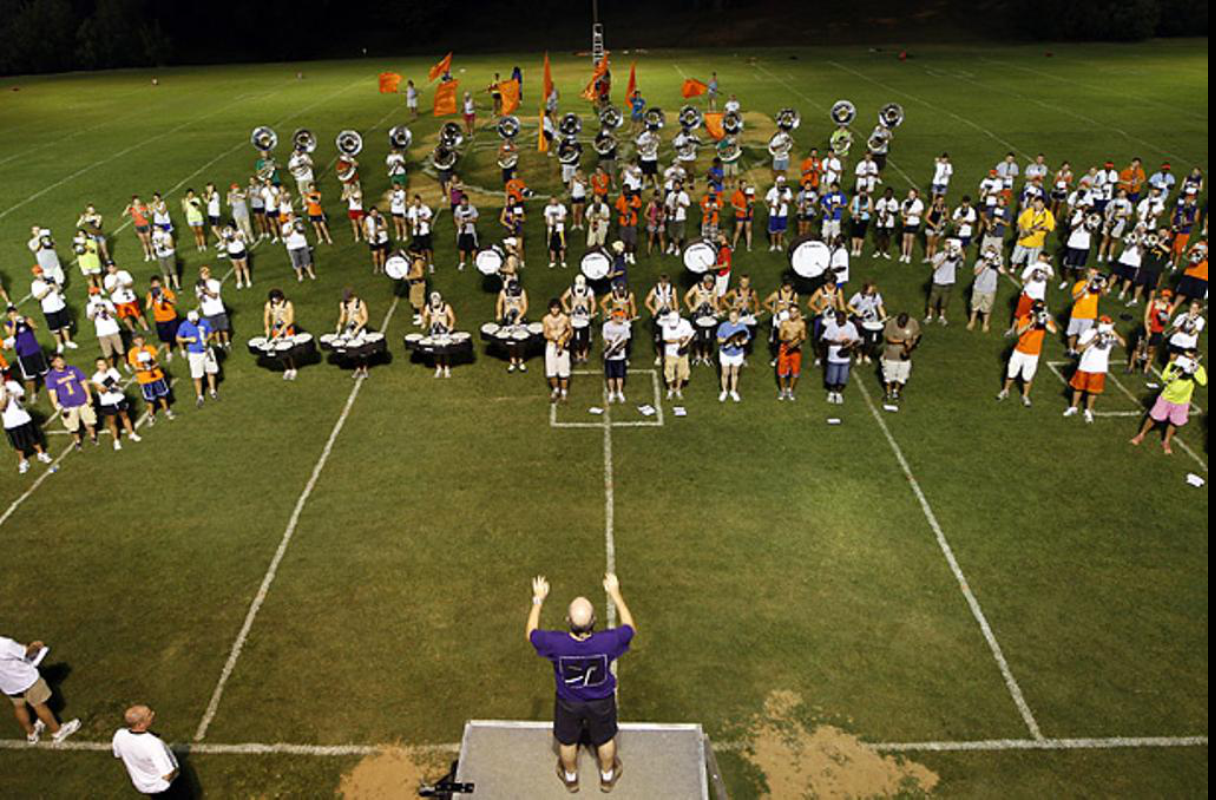

(torch.Size([3, 800, 1208]), torch.Size([3, 800, 1216]))

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(np.array(data[0]['image'].permute(1,2,0))[:,:,::-1])
cv2_imshow(np.array(traceable_inputs[0][0].permute(1,2,0).cpu())[:,:,::-1]) 
data[0]['image'].size(), traceable_inputs[0][0].size()


<br>


---

[Spis treści](https://github.com/DarekGit/FACES_DNN/blob/master/notebooks/Praca_Dyplomowa.ipynb) | [1. Wstęp](01_00_Wstep.ipynb) | [2. Metryki oceny detekcji](02_00_Miary.ipynb) | [3 .Bazy danych](03_00_Datasety.ipynb) | [4. Przegląd metod detekcji](04_00_Modele.ipynb) | [5. Detekcja twarzy z wykorzystaniem wybranych architektur GSN](05_00_Modyfikacje.ipynb) | [6. Porównanie modeli](06_00_Porownanie.ipynb) | [7. Eksport modelu](07_00_Eksport_modelu.ipynb) | [8. Podsumowanie i wnioski](08_00_Podsumowanie.ipynb) | [Bibliografia](Bibliografia.ipynb)


---
